# MovieLens Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install --upgrade wandb --quiet
import hashlib
import json
import pandas as pd
from collections import Counter

import wandb
wandb.login()

Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: arhaan (arhaan-dhirubhai-ambani-institute-of-information-and-com) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
run=wandb.init(
    project="JustiFlicks",
    job_type="preprocess",
    name="01_process_movies",
    config={
        "input": "/content/drive/My Drive/JustiFlicks/data_raw/MovieLens/ml-32m/movies.csv",
        "output": "/content/drive/My Drive/JustiFlicks/data_processed/movieTags.parquet",
        "notes": "Initial cleaning of MovieLens movies table"
    }
)

cfg=wandb.config

def md5_of_file(path,chunk_size=8192):
    h=hashlib.md5()
    with open(path,'rb') as f:
        while True:
            chunk=f.read(chunk_size)
            if not chunk:
                break
            h.update(chunk)
    return h.hexdigest()

movies=pd.read_csv(cfg.input)
print(movies.shape)
movies.head()

(87585, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87585 entries, 0 to 87584
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  87585 non-null  int64 
 1   title    87585 non-null  object
 2   genres   87585 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.0+ MB


In [4]:
movies2=movies.copy()
print(movies2.shape)

dup_count=movies2['movieId'].duplicated().sum()
print(dup_count)
movies2=movies2.drop_duplicates()

movies2['title']=movies2['title'].astype(str).str.replace(
    r'\s*\(\d{4}\)\s*$','',regex=True
).str.strip()

tags=pd.read_csv("/content/drive/My Drive/JustiFlicks/data_raw/MovieLens/ml-32m/tags.csv")
orig_rows=len(tags)

tags_df=tags.copy()
tags_df['tag_norm']=tags_df['tag'].astype(str).str.strip().str.lower()
grouped=tags_df.groupby('movieId')['tag_norm'].apply(list).reset_index(name='tag_norms')

def top_n_from_list(lst,n=20):
    c=Counter(lst)
    most=c.most_common(n)
    return [t for t,_ in most],[cnt for _,cnt in most]

grouped[['tag_list','tag_counts']]=grouped['tag_norms'].apply(
    lambda lst:pd.Series(top_n_from_list(lst,20))
)

movies2=movies2.merge(
    grouped[['movieId','tag_list','tag_counts']],
    on='movieId',
    how='left'
)

movies2['tag_list']=movies2['tag_list'].apply(lambda x:x if isinstance(x,list) else [])
movies2['tag_counts']=movies2['tag_counts'].apply(lambda x:x if isinstance(x,list) else [])

movieTags=movies2[['movieId','title','tag_list','tag_counts']].copy()

movieTags.to_parquet("/content/drive/My Drive/JustiFlicks/data_processed/movieTags.parquet",index=False)

checksum=md5_of_file("/content/drive/My Drive/JustiFlicks/data_processed/movieTags.parquet")

sample_n=10000
sample=movieTags.sample(n=sample_n,random_state=34)
sample.to_csv("/content/drive/My Drive/JustiFlicks/data_processed/movieTags_sample.csv",index=False)

manifest={
    "input":"/content/drive/My Drive/JustiFlicks/data_raw/MovieLens/ml-32m/tags.csv",
    "output":"/content/drive/My Drive/JustiFlicks/data_processed/movieTags.parquet",
    "rows_raw":orig_rows,
    "rows_processed":int(len(movieTags)),
    "checksum_md5":checksum
}
with open("/content/drive/My Drive/JustiFlicks/data_processed/movieTags_manifest.json","w") as mf:
    json.dump(manifest,mf)

wandb.login()
run=wandb.init(project="JustiFlicks",job_type="preprocess",name="01_process_movies")

artifact=wandb.Artifact(
    name="movieTags",
    type="dataset",
    metadata=manifest
)

artifact.add_file("/content/drive/My Drive/JustiFlicks/data_processed/movieTags.parquet")
artifact.add_file("/content/drive/My Drive/JustiFlicks/data_processed/movieTags_sample.csv")
artifact.add_file("/content/drive/My Drive/JustiFlicks/data_processed/movieTags_manifest.json")

run.log_artifact(artifact)
artifact.wait()
run.finish()

print(checksum)

(87585, 3)
0


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


f19a5b3111cfa41168fd25b636df268a


In [ ]:
movieTags.head(3)

,movieId,title,tag_list,tag_counts
0,1,Toy Story,"[pixar, animation, disney, funny, tom hanks, c...","[131, 78, 57, 50, 48, 39, 39, 35, 31, 30, 30, ..."
1,2,Jumanji,"[robin williams, fantasy, time travel, board g...","[48, 32, 26, 20, 14, 13, 13, 11, 10, 7, 7, 6, ..."
2,3,Grumpier Old Men,"[comedinha de velhinhos engraãƒâ§ada, comedinh...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [ ]:
movieTags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87585 entries, 0 to 87584
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   movieId     87585 non-null  int64 
 1   title       87585 non-null  object
 2   tag_list    87585 non-null  object
 3   tag_counts  87585 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.7+ MB


In [ ]:
movieTags.tail(3)

,movieId,title,tag_list,tag_counts
87582,292753,Orca,[],[]
87583,292755,The Angry Breed,[],[]
87584,292757,Race to the Summit,[],[]


In [5]:
ratings=pd.read_csv("/content/drive/My Drive/JustiFlicks/data_raw/MovieLens/ml-32m/ratings.csv")
orig_rows=len(ratings)

ratings['userId']=pd.to_numeric(ratings['userId'],errors='coerce').astype('Int64')
ratings['movieId']=pd.to_numeric(ratings['movieId'],errors='coerce').astype('Int64')
ratings['rating']=pd.to_numeric(ratings['rating'],errors='coerce').astype('float64')
ratings['timestamp']=pd.to_numeric(ratings['timestamp'],errors='coerce').astype('Int64')
ratings=ratings.dropna(subset=['userId','movieId','rating','timestamp'])

ratings['datetime']=pd.to_datetime(ratings['timestamp'],unit='s',utc=True).dt.tz_localize(None)
ratings=ratings.sort_values(by=['userId','movieId','datetime'])
before_dedup=len(ratings)
ratings=ratings.drop_duplicates(subset=['userId','movieId'],keep='last')
dedup_removed=before_dedup-len(ratings)

ratings=ratings.drop(columns=['timestamp'])

ratings.to_parquet("/content/drive/My Drive/JustiFlicks/data_processed/movieRatings.parquet",index=False)

checksum=md5_of_file("/content/drive/My Drive/JustiFlicks/data_processed/movieRatings.parquet")

sample_n=10000
sample=ratings.sample(n=sample_n,random_state=34)
sample.to_csv("/content/drive/My Drive/JustiFlicks/data_processed/movieRatings_sample.csv",index=False)

manifest={
    "input":"/content/drive/My Drive/JustiFlicks/data_raw/MovieLens/ml-32m/ratings.csv",
    "output":"/content/drive/My Drive/JustiFlicks/data_processed/movieRatings.parquet",
    "rows_raw":orig_rows,
    "rows_processed":int(len(ratings)),
    "unique_users":int(ratings['userId'].nunique()),
    "unique_movies":int(ratings['movieId'].nunique()),
    "checksum_md5":checksum
}
with open("/content/drive/My Drive/JustiFlicks/data_processed/movieRatings_manifest.json", "w") as mf:
    json.dump(manifest, mf)

wandb.login()
run=wandb.init(project="JustiFlicks",job_type="preprocess",name="02_process_ratings")

artifact=wandb.Artifact(name="movieLinks",type="dataset",metadata=manifest)
artifact.add_file("/content/drive/My Drive/JustiFlicks/data_processed/movieRatings_sample.csv")
artifact.add_file("/content/drive/My Drive/JustiFlicks/data_processed/movieRatings_manifest.json")
run.log_artifact(artifact)
artifact.wait()
run.finish()

print(checksum)

85b7b20ce89b094df31edcd325bc2d8c


In [ ]:
ratings.head()

,userId,movieId,rating,datetime
0,1,17,4.0,1999-12-03 19:24:37
1,1,25,1.0,1999-12-03 19:43:48
2,1,29,2.0,1999-11-22 00:36:16
3,1,30,5.0,1999-12-03 19:24:37
4,1,32,5.0,1999-11-22 00:00:58


In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000204 entries, 0 to 32000203
Data columns (total 4 columns):
 #   Column    Dtype        
---  ------    -----        
 0   userId    Int64        
 1   movieId   Int64        
 2   rating    float64      
 3   datetime  datetime64[s]
dtypes: Int64(2), datetime64[s](1), float64(1)
memory usage: 1.0 GB


In [6]:
links=pd.read_csv("/content/drive/My Drive/JustiFlicks/data_raw/MovieLens/ml-32m/links.csv")
orig_rows=len(links)

links['movieId']=pd.to_numeric(links['movieId'],errors='coerce').astype('Int64')
links['tmdbId']=pd.to_numeric(links['tmdbId'],errors='coerce').astype('Int64')
links['imdbId']=pd.to_numeric(links['imdbId'],errors='coerce').astype('Int64')

links=links.dropna(subset=['movieId'])
links=links.drop_duplicates()

dup_movieid=links['movieId'].duplicated().sum()
if dup_movieid>0:
    links=links.drop_duplicates(subset=['movieId'],keep='first')

links.to_parquet("/content/drive/My Drive/JustiFlicks/data_processed/movieLinks.parquet",index=False)

checksum=md5_of_file("/content/drive/My Drive/JustiFlicks/data_processed/movieLinks.parquet")

sample_n=10000
sample=links.sample(n=min(sample_n,len(links)),random_state=34)
sample.to_csv("/content/drive/My Drive/JustiFlicks/data_processed/movieLinks_sample.csv",index=False)

manifest={
    "input":"/content/drive/My Drive/JustiFlicks/data_raw/MovieLens/ml-32m/links.csv",
    "output":"/content/drive/My Drive/JustiFlicks/data_processed/movieLinks.parquet",
    "rows_raw":orig_rows,
    "rows_processed":int(len(links)),
    "unique_movies":int(links['movieId'].nunique()),
    "unique_imdb":int(links['imdbId'].nunique()),
    "unique_tmdb":int(links['tmdbId'].nunique()),
    "checksum_md5":checksum
}
with open("/content/drive/My Drive/JustiFlicks/data_processed/movieLinks_manifest.json","w") as mf:
    json.dump(manifest,mf)

run=wandb.init(project="JustiFlicks",job_type="preprocess",name="03_process_links")

artifact=wandb.Artifact(
    name="movieLinks",
    type="dataset",
    metadata=manifest
)

artifact.add_file("/content/drive/My Drive/JustiFlicks/data_processed/movieLinks.parquet")
artifact.add_file("/content/drive/My Drive/JustiFlicks/data_processed/movieLinks_sample.csv")
artifact.add_file("/content/drive/My Drive/JustiFlicks/data_processed/movieLinks_manifest.json")

run.log_artifact(artifact)
artifact.wait()
run.finish()

print(checksum)

c0b4901064910b13eb3d046ffbe87a97


In [ ]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87585 entries, 0 to 87584
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   movieId  87585 non-null  Int64
 1   imdbId   87585 non-null  Int64
 2   tmdbId   87461 non-null  Int64
dtypes: Int64(3)
memory usage: 2.3 MB


In [7]:
ratings=pd.read_csv("/content/drive/My Drive/JustiFlicks/data_raw/MovieLens/ml-32m/ratings.csv")
orig_rows=len(ratings)

ratings['userId']=pd.to_numeric(ratings['userId'],errors='coerce').astype('Int64')
ratings['movieId']=pd.to_numeric(ratings['movieId'],errors='coerce').astype('Int64')
ratings['rating']=pd.to_numeric(ratings['rating'],errors='coerce').astype('float64')
ratings['timestamp']=pd.to_numeric(ratings['timestamp'],errors='coerce').astype('Int64')

ratings=ratings.dropna(subset=['userId','movieId','rating','timestamp'])
ratings['datetime']=pd.to_datetime(ratings['timestamp'],unit='s',utc=True).dt.tz_localize(None)
ratings=ratings.sort_values(by=['userId','movieId','datetime'])
ratings=ratings.drop_duplicates(subset=['userId','movieId'],keep='last')

users=ratings.groupby('userId').agg(
    rating_count=('rating','count'),
    first_rating=('datetime','min'),
    last_rating=('datetime','max')
).reset_index()
users['userId']=users['userId'].astype('Int64')
users['rating_count']=users['rating_count'].astype('int64')

users.to_parquet("/content/drive/My Drive/JustiFlicks/data_processed/Users.parquet",index=False)

checksum=md5_of_file("/content/drive/My Drive/JustiFlicks/data_processed/Users.parquet")

sample_n=10000
sample=users.sample(n=min(sample_n,len(users)),random_state=34)
sample.to_csv("/content/drive/My Drive/JustiFlicks/data_processed/Users_sample.csv",index=False)

manifest={
    "input":"/content/drive/My Drive/JustiFlicks/data_raw/MovieLens/ml-32m/ratings.csv",
    "output":"/content/drive/My Drive/JustiFlicks/data_processed/Users.parquet",
    "rows_raw":orig_rows,
    "rows_processed":int(len(users)),
    "unique_users":int(users['userId'].nunique()),
    "checksum_md5":checksum
}
with open("/content/drive/My Drive/JustiFlicks/data_processed/Users_manifest.json","w") as mf:
    json.dump(manifest,mf)

run=wandb.init(project="JustiFlicks",job_type="preprocess",name="04_process_users")

artifact=wandb.Artifact(
    name="Users",
    type="dataset",
    metadata=manifest
)

artifact.add_file("/content/drive/My Drive/JustiFlicks/data_processed/Users.parquet")
artifact.add_file("/content/drive/My Drive/JustiFlicks/data_processed/Users_sample.csv")
artifact.add_file("/content/drive/My Drive/JustiFlicks/data_processed/Users_manifest.json")

run.log_artifact(artifact)
artifact.wait()
run.finish()

print(checksum)

858de72f86c182feff0d84193ade8c72


In [ ]:
users.head()

,userId,rating_count,first_rating,last_rating
0,1,141,1999-11-21 23:27:26,1999-12-03 21:26:38
1,2,52,1996-07-03 19:46:41,1996-07-03 20:04:01
2,3,147,2004-05-13 21:39:14,2004-05-13 22:09:24
3,4,27,2000-06-08 17:27:14,2000-06-08 17:35:23
4,5,33,1996-08-23 01:31:53,1996-08-23 02:54:57


In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200948 entries, 0 to 200947
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype        
---  ------        --------------   -----        
 0   userId        200948 non-null  Int64        
 1   rating_count  200948 non-null  int64        
 2   first_rating  200948 non-null  datetime64[s]
 3   last_rating   200948 non-null  datetime64[s]
dtypes: Int64(1), datetime64[s](2), int64(1)
memory usage: 6.3 MB


# TMDb + IMDb Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import wandb
import re
import html
import unicodedata
from collections import Counter
import hashlib
import json

wandb.login()

MIN_ACTOR_APPEARANCES=5
MIN_DIRECTOR_APPEARANCES=2
MIN_WRITER_APPEARANCES=3

MIN_COMPANY_APPEARANCES=50
MIN_COUNTRY_APPEARANCES=50
MIN_LANGUAGE_APPEARANCES=100

df=pd.read_csv("/content/drive/My Drive/JustiFlicks/data_raw/TMDB  IMDB Movies Dataset.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def normalize_cast(c):
    if not isinstance(c,str):
        return []
    names=[n.strip().lower() for n in c.split(',')]
    names=[re.sub(r'\s+',' ',n) for n in names if n]
    return list(dict.fromkeys(names))

def clean_text(s):
    if not isinstance(s,str):
        return s
    s=html.unescape(s)
    s=re.sub(r'[\x00-\x1f\x7f]', '', s)
    s=re.sub(r'\s+', ' ', s)
    return s.strip()

def strip_unify_name(s):
    if not isinstance(s,str):
        return s
    s=s.strip()
    s=re.sub(r'\s+',' ',s)
    s=unicodedata.normalize('NFKD',s)
    s=s.encode('ascii','ignore').decode('ascii')
    return s.title()

def parse_list_field(s,sep=',',normalize_fn=lambda x:x):
    if not isinstance(s,str) or not s.strip():
        return []
    parts=[p.strip() for p in s.split(sep) if p.strip()]
    return [normalize_fn(p) for p in parts]

def normalize_name(s):
    if not isinstance(s,str):
        return s
    s=s.strip()
    s=re.sub(r'\s+',' ',s)
    s=unicodedata.normalize('NFKD',s)
    s=s.encode('ascii','ignore').decode('ascii')
    return s

def parse_list(s):
    if not isinstance(s,str) or not s.strip():
        return []
    return [normalize_name(x) for x in s.split(',') if x.strip()]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434119 entries, 0 to 434118
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    434119 non-null  int64  
 1   title                 434119 non-null  object 
 2   vote_average          434119 non-null  float64
 3   vote_count            434119 non-null  int64  
 4   status                434119 non-null  object 
 5   release_date          413958 non-null  object 
 6   revenue               434119 non-null  int64  
 7   runtime               434119 non-null  int64  
 8   adult                 434119 non-null  bool   
 9   backdrop_path         184646 non-null  object 
 10  budget                434119 non-null  int64  
 11  homepage              54471 non-null   object 
 12  tconst                434119 non-null  object 
 13  original_language     434119 non-null  object 
 14  original_title        434119 non-null  object 
 15  

In [ ]:
with pd.option_context('display.max_columns', None):
    display(df.head())

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,budget,homepage,tconst,original_language,original_title,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,keywords,directors,writers,averageRating,numVotes,cast
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,160000000,https://www.warnerbros.com/movies/inception,tt1375666,en,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,/oYuLEt3zVCKq57qu2F8dT7NIa6f.jpg,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc...",Christopher Nolan,Christopher Nolan,8.8,2758879,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ken W..."
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,False,/pbrkL804c8yAv3zBZR4QPEafpAR.jpg,165000000,http://www.interstellarmovie.net/,tt0816692,en,Interstellar,The adventures of a group of explorers who mak...,140.241,/gEU2QniE6E77NI6lCU6MxlNBvIx.jpg,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,...",Christopher Nolan,"Jonathan Nolan, Christopher Nolan",8.7,2440324,"Matthew McConaughey, Anne Hathaway, Michael Ca..."
2,155,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,False,/nMKdUUepR0i5zn0y1T4CsSB5chy.jpg,185000000,https://www.warnerbros.com/movies/dark-knight/,tt0468569,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,/qJ2tW6WMUDux911r6m7haRef0WH.jpg,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f...",Christopher Nolan,"Jonathan Nolan, Christopher Nolan, David S. Go...",9.1,3104589,"Christian Bale, Heath Ledger, Aaron Eckhart, M..."
3,19995,Avatar,7.573,29815,Released,2009-12-15,2923706026,162,False,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,237000000,https://www.avatar.com/movies/avatar,tt0499549,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",79.932,/kyeqWdyUXW608qlYkRqosgbbJyK.jpg,Enter the world of Pandora.,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ...",James Cameron,James Cameron,7.9,1455251,"Sam Worthington, Zoe Saldaña, Sigourney Weaver..."
4,24428,The Avengers,7.710,29166,Released,2012-04-25,1518815515,143,False,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,220000000,https://www.marvel.com/movies/the-avengers,tt0848228,en,The Avengers,When an unexpected enemy emerges and threatens...,98.082,/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg,Some assembly required.,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com...",Joss Whedon,"Joss Whedon, Zak Penn",8.0,1535259,"Robert Downey Jr., Chris Evans, Mark Ruffalo, ..."


In [ ]:
display(df['status'].value_counts())
df2=df[df['status']=="Released"].copy()

id_dup_count=df2['id'].duplicated().sum()
df2['imdbId']=(
    df2['tconst']
    .astype(str)
    .str.replace('tt','',regex=False)
)


df2=df2.drop(columns=['status','tconst'])
df2['imdbId']=pd.to_numeric(df2['imdbId'],errors='coerce').astype('int64')

dup_tconst_int=df2['imdbId'].duplicated().sum()

print("Duplicate Imdb IDs:",dup_tconst_int)
print("Duplicate Tmdb IDs:",id_dup_count)

,count
status,
Released,431230
Post Production,1674
In Production,1037
Planned,164
Canceled,9
Rumored,5


Duplicate Imdb IDs: 6676
Duplicate Tmdb IDs: 4946


In [ ]:
cols_no_cast=[c for c in df2.columns if c!="cast"]

dup_mask_no_cast=df2.duplicated(subset=cols_no_cast,keep=False)
dup_rows_no_cast=df2[dup_mask_no_cast]

print("duplicate_rows_excluding_cast=",len(dup_rows_no_cast))
display(dup_rows_no_cast.sort_values(['imdbId','id'])[['id','imdbId','cast']])

duplicate_rows_excluding_cast= 6578


,id,imdbId,cast
286512,1185482,3037,NaN
286513,1185482,3037,"Georges Melchior, René Navarre"
300317,1317649,3037,NaN
300318,1317649,3037,"Georges Melchior, René Navarre"
302828,1412321,3037,NaN
...,...,...,...
238819,1589311,33998607,"Cocoro Kikuchi, Yasuyuki Kase, Jiro Saito, Yuk..."
297658,1373658,34000798,"Margot Robbie, Jacob Elordi"
297659,1373658,34000798,NaN
301902,1418306,34000798,"Margot Robbie, Jacob Elordi"


In [ ]:
df3=df2.copy()

df3['cast_norm']=df3['cast'].apply(normalize_cast)
df3['cast_count']=df3['cast_norm'].apply(len)

df3_valid=df3[df3['imdbId'].notna()].copy()

df3_valid=df3_valid.sort_values(
    by=['imdbId','cast_count'],
    ascending=[True,False]
)

df3_best=df3_valid.drop_duplicates(
    subset=['imdbId'],
    keep='first'
)

df3=df3_best.drop(columns=['cast_norm','cast_count'])

print("rows_before=",len(df2))
print("rows_after=",len(df3))
print("unique_imdbId=",df3['imdbId'].nunique())
with pd.option_context('display.max_columns', None):
    display(df3.head())

rows_before= 431230
rows_after= 424554
unique_imdbId= 424554


,id,title,vote_average,vote_count,release_date,revenue,runtime,adult,backdrop_path,budget,homepage,original_language,original_title,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,keywords,directors,writers,averageRating,numVotes,cast,imdbId
23988,16612,Carmencita,5.200,64,1894-03-14,0,1,False,NaN,0,NaN,xx,Carmencita,The first woman to appear in front of an Ediso...,3.092,/sDbM3NnfnsEZYEJMt4O06Vb8Z9k.jpg,NaN,Documentary,Edison Studios,United States of America,No Language,"dancer, silent film",William K.L. Dickson,NaN,5.7,2188,Carmencita,1
76012,16613,Clown and His Dogs,4.700,10,1892-10-28,0,10,False,/pfeS2kjgvrjsCaKQ2NCFR22b9aR.jpg,0,https://www.emilereynaud.fr/index.php/post/Clo...,fr,Clown et ses chiens,Short film of 300 individually painted images.,2.072,/4ACC8V9ZSZ9AlWcAqUeF8aMcZV6.jpg,NaN,Animation,NaN,France,No Language,"clown, dog, silent film, 19th century, circus ...",Émile Reynaud,NaN,5.5,307,NaN,2
20005,88013,Poor Pierrot,6.029,86,1892-10-28,0,4,False,/tXPCJDP3oXJi91TVaxV0CUZdfZc.jpg,0,NaN,fr,Pauvre Pierrot,"One night, Arlequin comes to see his lover Col...",3.684,/1e2ytD2cSxAz1r0SItxDmZUPb4i.jpg,NaN,"Comedy, Animation",NaN,France,French,"19th century, short film, pierrot, arlequin, t...",Émile Reynaud,Émile Reynaud,6.4,2274,NaN,3
90118,16622,A Good Beer,4.000,8,1892-10-28,0,15,False,NaN,0,https://www.emilereynaud.fr/index.php/post/Un-...,fr,Un bon bock,NaN,1.168,/osv0TcCymlsOucqkZBssSuS4tD.jpg,NaN,Animation,NaN,France,No Language,"19th century, short film, théâtre optique, les...",Émile Reynaud,NaN,5.1,197,NaN,4
19778,16624,Blacksmith Scene,5.511,87,1893-05-08,0,1,False,NaN,0,NaN,xx,Blacksmith Scene,Three men hammer on an anvil and pass a bottle...,3.675,/c76bs0S90EFhB5ww3i6DlYQTVk.jpg,NaN,"Drama, Documentary",Edison Studios,United States of America,No Language,"blacksmith, beer, workmen",William K.L. Dickson,NaN,6.2,3012,"Charles Kayser, John Ott",5


In [ ]:
df4=df3.copy()

df4['title']=df4['title'].astype(str)

df4['release_date']=pd.to_datetime(df4['release_date'],errors='coerce')

today=pd.Timestamp.today()

invalid_date_mask=(
    df4['release_date'].notna() &
    (
        (df4['release_date']>today) |
        (df4['release_date'].dt.year<1800)
    )
)

df4=df4[~invalid_date_mask]

df4['has_release_date']=df4['release_date'].notna()
df4['release_year']=df4['release_date'].dt.year.astype('Int64')

df4['runtime']=pd.to_numeric(df4['runtime'],errors='coerce').astype('Int64')
df4.loc[(df4['runtime']<1)|(df4['runtime']>500),'runtime']=pd.NA

df4['budget']=pd.to_numeric(df4['budget'],errors='coerce')
df4.loc[df4['budget']<=0,'budget']=np.nan
df4['budget']=df4['budget'].astype('Int64')

df4['revenue']=pd.to_numeric(df4['revenue'],errors='coerce')
df4.loc[df4['revenue']<=0,'revenue']=np.nan
df4['revenue']=df4['revenue'].astype('Int64')

df4=df4.rename(columns={
    'vote_average':'average_rating_tmdb',
    'vote_count':'num_votes_tmdb',
    'averageRating':'average_rating_imdb',
    'numVotes':'num_votes_imdb'
})

df4['average_rating_tmdb']=pd.to_numeric(df4['average_rating_tmdb'],errors='coerce')
df4['num_votes_tmdb']=pd.to_numeric(df4['num_votes_tmdb'],errors='coerce').astype('Int64')

df4['average_rating_imdb']=pd.to_numeric(df4['average_rating_imdb'],errors='coerce')
df4['num_votes_imdb']=pd.to_numeric(df4['num_votes_imdb'],errors='coerce').astype('Int64')

df4.loc[df4['num_votes_tmdb']==0,'average_rating_tmdb']=np.nan
df4.loc[df4['num_votes_imdb']==0,'average_rating_imdb']=np.nan

print("rows_after_cleaning=",len(df4))
print("missing_runtime=",df4['runtime'].isna().sum())
print("missing_budget=",df4['budget'].isna().sum())
print("missing_revenue=",df4['revenue'].isna().sum())

rows_after_cleaning= 424552
missing_runtime= 53871
missing_budget= 395984
missing_revenue= 408392


In [ ]:
display(df4['original_language'].value_counts())

lang_map={
    'cn':'zh',
    'mo':'ro',
    'sh':'sr',
    'xx':None
}

df4['original_language']=(
    df4['original_language']
    .astype(str)
    .str.lower()
    .replace(lang_map)
)

df4.loc[df4['original_language']=='none','original_language']=pd.NA

lang_counts=df4['original_language'].value_counts(dropna=True)
rare_langs=lang_counts[lang_counts<100].index

df4.loc[
    df4['original_language'].isin(rare_langs),
    'original_language'
]='other'


,count
original_language,
en,227820
fr,24469
es,21449
de,21273
ja,13000
...,...
ba,1
su,1
kw,1


In [ ]:
df4['has_budget']=df4['budget'].notna()
df4['has_revenue']=df4['revenue'].notna()

df4['has_poster']=df4['poster_path'].notna()
df4['has_backdrop']=df4['backdrop_path'].notna()

tmdb_img_base="https://image.tmdb.org/t/p/w500"

df4['poster_url']=np.where(
    df4['poster_path'].notna(),
    tmdb_img_base+df4['poster_path'],
    pd.NA
)

df4['backdrop_url']=np.where(
    df4['backdrop_path'].notna(),
    tmdb_img_base+df4['backdrop_path'],
    pd.NA
)

df4['overview']=df4['overview'].apply(clean_text)
df4['tagline']=df4['tagline'].apply(clean_text)
df4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 424552 entries, 23988 to 297883
Data columns (total 36 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    424552 non-null  int64         
 1   title                 424552 non-null  object        
 2   average_rating_tmdb   268208 non-null  float64       
 3   num_votes_tmdb        424552 non-null  Int64         
 4   release_date          409049 non-null  datetime64[ns]
 5   revenue               16160 non-null   Int64         
 6   runtime               370681 non-null  Int64         
 7   adult                 424552 non-null  bool          
 8   backdrop_path         181959 non-null  object        
 9   budget                28568 non-null   Int64         
 10  homepage              53272 non-null   object        
 11  original_language     423390 non-null  object        
 12  original_title        424552 non-null  object        
 13  

In [ ]:
df4["cast_list"] = (
    df4["cast"]
    .fillna("")
    .apply(lambda x: [a.strip() for a in x.split(",") if a.strip()])
)

actor_counts = Counter(
    actor
    for cast in df4["cast_list"]
    for actor in cast
)

frequent_actors = {
    actor for actor, c in actor_counts.items()
    if c >= MIN_ACTOR_APPEARANCES
}

def count_kept_actors(cast_list):
    return sum(actor in frequent_actors for actor in cast_list)

df4["kept_actor_count"] = df4["cast_list"].apply(count_kept_actors)
df4["kept_actor_count"].describe()


,kept_actor_count
count,424552.000000
mean,4.131256
std,3.599272
min,0.000000
25%,0.000000
50%,4.000000
75%,8.000000
max,13.000000


In [ ]:
df5=df4.copy()

df5['genres']=df5['genres'].apply(lambda x: parse_list_field(x,sep=',',normalize_fn=lambda g:g.strip().lower()))

df5['directors']=df5['directors'].apply(lambda x: parse_list_field(x,sep=',',normalize_fn=strip_unify_name))
df5['writers']=df5['writers'].apply(lambda x: parse_list_field(x,sep=',',normalize_fn=strip_unify_name))
df5['cast_list']=df5['cast'].apply(lambda x: parse_list_field(x,sep=',',normalize_fn=strip_unify_name))

actor_counts=Counter(actor for cast in df5['cast_list'] for actor in cast)

frequent_actors={actor for actor,count in actor_counts.items() if count>=MIN_ACTOR_APPEARANCES}

def group_actor_name(a):
    return a if a in frequent_actors else 'rare_actor'

df5['cast_list'] = df5['cast_list'].apply(lambda lst:[group_actor_name(a) for a in lst])

actor_to_weight={}
for actor,count in actor_counts.items():
    if count<MIN_ACTOR_APPEARANCES:
        actor_to_weight[actor]=0.1
    else:
        actor_to_weight[actor]=float(np.log1p(count))

def weights_for_list(lst):
    return [actor_to_weight.get(a,0.1) for a in lst]

df5['cast_weight']=df5['cast_list'].apply(lambda lst:[actor_to_weight.get(a,0.1) if a!='rare_actor' else 0.1 for a in lst])

director_counts=Counter(d for dirs in df5['directors'] for d in dirs)
writer_counts=Counter(w for writers in df5['writers'] for w in writers)

def group_directors(lst):
    return [d if director_counts.get(d,0)>=MIN_DIRECTOR_APPEARANCES else 'rare_director' for d in lst]

def group_writers(lst):
    return [w if writer_counts.get(w,0)>=MIN_WRITER_APPEARANCES else 'rare_writer' for w in lst]

df5['directors']=df5['directors'].apply(group_directors)
df5['writers']=df5['writers'].apply(group_writers)

df5.drop(columns=['kept_actor_count','backdrop_path','poster_path','cast','homepage'],inplace=True)


In [ ]:
df5['production_companies']=df5['production_companies'].apply(parse_list)
df5['production_countries']=df5['production_countries'].apply(parse_list)
df5['spoken_languages']=df5['spoken_languages'].apply(parse_list)

company_counts=Counter(c for lst in df5['production_companies'] for c in lst)
country_counts=Counter(c for lst in df5['production_countries'] for c in lst)
language_counts=Counter(l for lst in df5['spoken_languages'] for l in lst)

frequent_companies={c for c,n in company_counts.items() if n>=MIN_COMPANY_APPEARANCES}
frequent_countries={c for c,n in country_counts.items() if n>=MIN_COUNTRY_APPEARANCES}
frequent_languages={l for l,n in language_counts.items() if n>=MIN_LANGUAGE_APPEARANCES}

def group_companies(lst):
    return [c if c in frequent_companies else 'other_company' for c in lst]

def group_languages(lst):
    return [l if l in frequent_languages else 'other_language' for l in lst]

def group_countries(lst):
    return [l if l in frequent_countries else 'other_country' for l in lst]


df5['production_companies']=df5['production_companies'].apply(group_companies)
df5['spoken_languages']=df5['spoken_languages'].apply(group_languages)
df5['production_countries']=df5['production_countries'].apply(group_countries)

df5['has_production_company']=df5['production_companies'].apply(bool)
df5['has_production_country']=df5['production_countries'].apply(bool)
df5['has_spoken_language']=df5['spoken_languages'].apply(bool)

df5['keywords_list']=df5['keywords'].apply(parse_list)
df5['has_keywords']=df5['keywords'].apply(bool)

df5=df5.rename(columns={
    'id':'tmdbId'
})

In [ ]:

df5["has_cast"]=df5["cast_list"].apply(lambda x:len(x)>0)
df5["has_directors"]=df5["directors"].apply(lambda x:len(x)>0)
df5["has_writers"]=df5["writers"].apply(lambda x:len(x)>0)

df5["has_overview"] = df5["overview"].notna() & (df5["overview"].str.strip() != "")
df5["has_tagline"]  = df5["tagline"].notna() & (df5["tagline"].str.strip() != "")
df5["has_runtime"]  = df5["runtime"].notna()

new_column_order=[
    # 1. ID
    'imdbId',
    'tmdbId',

    # 2. Core metadata
    'title',
    'original_title',
    'original_language',
    'release_date',
    'release_year',
    'has_release_date',
    'adult',

    # 3. Content
    'overview',
    'tagline',
    'genres',
    'keywords',
    'keywords_list',
    'has_overview',
    'has_tagline',
    'has_keywords',

    # 4. People
    'cast_list',
    'cast_weight',
    'directors',
    'writers',
    'has_cast',
    'has_directors',
    'has_writers',

    # 5. Production
    'production_companies',
    'production_countries',
    'spoken_languages',
    'has_production_company',
    'has_production_country',
    'has_spoken_language',

    # 6. Ratings
    'average_rating_tmdb',
    'num_votes_tmdb',
    'average_rating_imdb',
    'num_votes_imdb',
    'popularity',
    'runtime',
    'has_runtime',

    # 7. Finance
    'budget',
    'revenue',
    'has_budget',
    'has_revenue',

    # 8. Pictures
    'poster_url',
    'backdrop_url',
    'has_poster',
    'has_backdrop'
]

df5=df5[new_column_order]
df5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 424552 entries, 23988 to 297883
Data columns (total 45 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   imdbId                  424552 non-null  int64         
 1   tmdbId                  424552 non-null  int64         
 2   title                   424552 non-null  object        
 3   original_title          424552 non-null  object        
 4   original_language       423390 non-null  object        
 5   release_date            409049 non-null  datetime64[ns]
 6   release_year            409049 non-null  Int64         
 7   has_release_date        424552 non-null  bool          
 8   adult                   424552 non-null  bool          
 9   overview                384843 non-null  object        
 10  tagline                 89876 non-null   object        
 11  genres                  424552 non-null  object        
 12  keywords                168573 

In [ ]:
output_path="/content/drive/My Drive/JustiFlicks/data_processed/movieData.parquet"
df5.to_parquet(output_path, index=False)

def md5_of_file(path,chunk_size=8192):
    h=hashlib.md5()
    with open(path,'rb') as f:
        while True:
            chunk=f.read(chunk_size)
            if not chunk:
                break
            h.update(chunk)
    return h.hexdigest()

checksum=md5_of_file(output_path)

sample_n=1000 if len(df5)>1000 else len(df5)
sample=df5.sample(n=sample_n,random_state=34)
sample_path="/content/drive/My Drive/JustiFlicks/data_processed/movieData_sample.csv"
sample.to_csv(sample_path,index=False)

dtypes={c:str(v) for c,v in df5.dtypes.items()}
missing={c:int(df5[c].isna().sum()) for c in df5.columns}

manifest={
    "input_sources":"TMDB + IMDb",
    "output":output_path,
    "rows_processed":int(len(df5)),
    "columns":int(len(df5.columns)),
    "columns_list":list(df5.columns),
    "dtypes":dtypes,
    "missing_counts":missing,
    "unique_tmdbId":int(df5['tmdbId'].nunique()) if 'tmdbId' in df5.columns else None,
    "unique_imdbId":int(df5['imdbId'].nunique()) if 'imdbId' in df5.columns else None,
    "sample_rows":int(sample_n),
    "checksum_md5":checksum
}

manifest_path="/content/drive/My Drive/JustiFlicks/data_processed/movieData_manifest.json"
with open(manifest_path,'w') as mf:
    json.dump(manifest,mf,indent=2)

wandb.login()
run=wandb.init(project="JustiFlicks",job_type="preprocess",name="05_process_movie_metadata")

artifact=wandb.Artifact(name="movieData",type="dataset",metadata=manifest)
artifact.add_file(sample_path)
artifact.add_file(manifest_path)
run.log_artifact(artifact)
artifact.wait()
run.finish()

print(checksum)
with pd.option_context('display.max_columns', None):
    display(df5.head())


9a1a364825c26b122d73000cb27eeb0c


,imdbId,tmdbId,title,original_title,original_language,release_date,release_year,has_release_date,adult,overview,tagline,genres,keywords,keywords_list,has_overview,has_tagline,has_keywords,cast_list,cast_weight,directors,writers,has_cast,has_directors,has_writers,production_companies,production_countries,spoken_languages,has_production_company,has_production_country,has_spoken_language,average_rating_tmdb,num_votes_tmdb,average_rating_imdb,num_votes_imdb,popularity,runtime,has_runtime,budget,revenue,has_budget,has_revenue,poster_url,backdrop_url,has_poster,has_backdrop
23988,1,16612,Carmencita,Carmencita,None,1894-03-14,1894,True,False,The first woman to appear in front of an Ediso...,NaN,[documentary],"dancer, silent film","[dancer, silent film]",True,False,True,[rare_actor],[0.1],[William K.L. Dickson],[],True,True,False,[Edison Studios],[United States of America],[No Language],True,True,True,5.200,64,5.7,2188,3.092,1,True,<NA>,<NA>,False,False,https://image.tmdb.org/t/p/w500/sDbM3NnfnsEZYE...,<NA>,True,False
76012,2,16613,Clown and His Dogs,Clown et ses chiens,fr,1892-10-28,1892,True,False,Short film of 300 individually painted images.,NaN,[animation],"clown, dog, silent film, 19th century, circus ...","[clown, dog, silent film, 19th century, circus...",True,False,True,[],[],[Emile Reynaud],[],False,True,False,[],[France],[No Language],False,True,True,4.700,10,5.5,307,2.072,10,True,<NA>,<NA>,False,False,https://image.tmdb.org/t/p/w500/4ACC8V9ZSZ9AlW...,https://image.tmdb.org/t/p/w500/pfeS2kjgvrjsCa...,True,True
20005,3,88013,Poor Pierrot,Pauvre Pierrot,fr,1892-10-28,1892,True,False,"One night, Arlequin comes to see his lover Col...",NaN,"[comedy, animation]","19th century, short film, pierrot, arlequin, t...","[19th century, short film, pierrot, arlequin, ...",True,False,True,[],[],[Emile Reynaud],[rare_writer],False,True,True,[],[France],[French],False,True,True,6.029,86,6.4,2274,3.684,4,True,<NA>,<NA>,False,False,https://image.tmdb.org/t/p/w500/1e2ytD2cSxAz1r...,https://image.tmdb.org/t/p/w500/tXPCJDP3oXJi91...,True,True
90118,4,16622,A Good Beer,Un bon bock,fr,1892-10-28,1892,True,False,NaN,NaN,[animation],"19th century, short film, théâtre optique, les...","[19th century, short film, theatre optique, le...",False,False,True,[],[],[Emile Reynaud],[],False,True,False,[],[France],[No Language],False,True,True,4.000,8,5.1,197,1.168,15,True,<NA>,<NA>,False,False,https://image.tmdb.org/t/p/w500/osv0TcCymlsOuc...,<NA>,True,False
19778,5,16624,Blacksmith Scene,Blacksmith Scene,None,1893-05-08,1893,True,False,Three men hammer on an anvil and pass a bottle...,NaN,"[drama, documentary]","blacksmith, beer, workmen","[blacksmith, beer, workmen]",True,False,True,"[rare_actor, rare_actor]","[0.1, 0.1]",[William K.L. Dickson],[],True,True,False,[Edison Studios],[United States of America],[No Language],True,True,True,5.511,87,6.2,3012,3.675,1,True,<NA>,<NA>,False,False,https://image.tmdb.org/t/p/w500/c76bs0S90EFhB5...,<NA>,True,False


# Exploratory Data Analysis

## Questions

1. How **sparse** is the user-movie interaction matrix, and where is the long tail?

2. Are movie ratings (vote counts, skew, variance) **reliable** and do small-vote movies show extreme/unstable averages?

3. What is the **coverage** and interaction-weighted coverage of key metadata fields (poster/ backdrop/overview/keywords/cast)?

4. What fraction of movies are **cold-start** and how does that fraction vary by popularity, year, and language?

5. Are there systematic coverage gaps that affect certain **slices** (era, language, popularity, genre, production country)?

###Prep

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import hashlib
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import wandb
wandb.login()
tags=pd.read_parquet("/content/drive/My Drive/JustiFlicks/data_processed/movieTags.parquet")
links=pd.read_parquet("/content/drive/My Drive/JustiFlicks/data_processed/movieLinks.parquet")
ratings=pd.read_parquet("/content/drive/My Drive/JustiFlicks/data_processed/movieRatings.parquet")
data=pd.read_parquet("/content/drive/My Drive/JustiFlicks/data_processed/movieData.parquet")
users=pd.read_parquet("/content/drive/My Drive/JustiFlicks/data_processed/Users.parquet")

Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: arhaan (arhaan-dhirubhai-ambani-institute-of-information-and-com) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
links_ids = set(links["tmdbId"])
df_ids = set(data["tmdbId"])

links_ids2 = set(links["imdbId"])
df_ids2 = set(data["imdbId"])

overlap = links_ids & df_ids
overlap2 = links_ids2 & df_ids2

print("Total movie entries:",len(links))
print("Overlapping Tmdb IDs:",len(overlap))
print("Overlapping Imdb IDs:",len(overlap2))

valid_movie_ids = set(data["imdbId"])

ratings["has_metadata"] = links["imdbId"].isin(valid_movie_ids)

ratings.head()

Total movie entries: 87585
Overlapping Tmdb IDs: 86139
Overlapping Imdb IDs: 86550


,userId,movieId,rating,datetime,has_metadata
0,1,17,4.0,1999-12-03 19:24:37,True
1,1,25,1.0,1999-12-03 19:43:48,True
2,1,29,2.0,1999-11-22 00:36:16,True
3,1,30,5.0,1999-12-03 19:24:37,True
4,1,32,5.0,1999-11-22 00:00:58,True


In [ ]:

ratings.to_parquet("/content/drive/My Drive/JustiFlicks/data_processed/movieRatings.parquet",index=False)

def md5_of_file(path,chunk_size=8192):
    h=hashlib.md5()
    with open(path,'rb') as f:
        while True:
            chunk=f.read(chunk_size)
            if not chunk:
                break
            h.update(chunk)
    return h.hexdigest()

checksum=md5_of_file("/content/drive/My Drive/JustiFlicks/data_processed/movieRatings.parquet")

sample_n=10000
sample=ratings.sample(n=sample_n,random_state=34)
sample.to_csv("/content/drive/My Drive/JustiFlicks/data_processed/movieRatings_sample.csv",index=False)

manifest={
    "input":"/content/drive/My Drive/JustiFlicks/data_raw/MovieLens/ml-32m/ratings.csv",
    "output":"/content/drive/My Drive/JustiFlicks/data_processed/movieRatings.parquet",
    "rows_raw":orig_rows,
    "rows_processed":int(len(ratings)),
    "unique_users":int(ratings['userId'].nunique()),
    "unique_movies":int(ratings['movieId'].nunique()),
    "checksum_md5":checksum
}
with open("/content/drive/My Drive/JustiFlicks/data_processed/movieRatings_manifest.json", "w") as mf:
    json.dump(manifest, mf)

wandb.login()
run=wandb.init(project="JustiFlicks",job_type="preprocess",name="02_process_ratings")

artifact=wandb.Artifact(name="movieLinks",type="dataset",metadata=manifest)
artifact.add_file("/content/drive/My Drive/JustiFlicks/data_processed/movieRatings_sample.csv")
artifact.add_file("/content/drive/My Drive/JustiFlicks/data_processed/movieRatings_manifest.json")
run.log_artifact(artifact)
artifact.wait()
run.finish()

print(checksum)

24b8236717d924b5a856555201b3381d


In [ ]:
num_cols=[
    "release_year",
    "average_rating_tmdb",
    "num_votes_tmdb",
    "average_rating_imdb",
    "num_votes_imdb",
    "popularity",
    "runtime",
    "budget",
    "revenue"
]

summary=data[num_cols].describe(percentiles=[0.001,0.01,0.99,0.999])

rules={
    "release_year":lambda s:(s<1870)|(s>2030),
    "average_rating_tmdb":lambda s:(s<0)|(s>10),
    "average_rating_imdb":lambda s:(s<0)|(s>10),
    "num_votes_tmdb":lambda s:s<0,
    "num_votes_imdb":lambda s:s<0,
    "runtime":lambda s:(s<=0)|(s>600),
    "budget":lambda s:s<0,
    "revenue":lambda s:s<0,
    "popularity":lambda s:s<0
}

rule_violations={
    col:data.loc[rules[col](data[col]),col].shape[0]
    for col in rules
}

{
    "summary_stats":summary,
    "rule_based_violations":rule_violations,
}

{'summary_stats':        release_year  average_rating_tmdb  num_votes_tmdb  average_rating_imdb  \
 count      409049.0        268208.000000        424552.0        424552.000000   
 mean    1994.297864             5.819334       50.180857             6.245616   
 std       27.347416             1.752016      519.643429             1.298798   
 min          1874.0             0.000000             0.0             1.000000   
 0.1%         1896.0             0.000000             0.0             1.600000   
 1%           1912.0             1.000000             0.0             2.700000   
 50%          2005.0             6.000000             1.0             6.400000   
 99%          2023.0            10.000000          902.49             9.000000   
 99.9%        2024.0            10.000000         7744.49             9.600000   
 max          2025.0            10.000000         34495.0            10.000000   
 
        num_votes_imdb     popularity    runtime           budget  \
 count    

### Q1. Sparsity Conclusion :
* User-movie interaction matrix is **extremely sparse**. (99.8% empty)
* User ratings are moderately dense (median 73 ratings), however movie ratings are dominated by a **long tail** (50% of movies have <=6 ratings) and model design musy account for it.
* Hence movie **cold-start** is a challenge, and that collaborative filtering alone will not generalize to most of the catalog.

In [ ]:
n_users=ratings["userId"].nunique()
n_movies=ratings["movieId"].nunique()
n_interactions=len(ratings)

sparsity=1-(n_interactions/(n_users*n_movies))

movie_rating_counts=ratings.groupby("movieId",sort=False).size()
user_rating_counts=ratings.groupby("userId",sort=False).size()

movie_rating_summary=movie_rating_counts.describe(percentiles=[0.25,0.5,0.75,0.95,0.99])
user_rating_summary=user_rating_counts.describe(percentiles=[0.25,0.5,0.75,0.95,0.99])

movie_long_tail_cdf=movie_rating_counts.value_counts().sort_index().cumsum()/len(movie_rating_counts)

result={
    "n_users":n_users,
    "n_movies":n_movies,
    "n_interactions":n_interactions,
    "sparsity":sparsity,
    "movie_rating_summary":movie_rating_summary,
    "user_rating_summary":user_rating_summary,
    "movie_long_tail_cdf":movie_long_tail_cdf.head(10)
}

with pd.option_context('display.max_columns', None):
    display(result)

{'n_users': 200948,
 'n_movies': 84432,
 'n_interactions': 32000204,
 'sparsity': 0.9981139118693746,
 'movie_rating_summary': count     84432.000000
 mean        379.005638
 std        2592.439791
 min           1.000000
 25%           2.000000
 50%           5.000000
 75%          25.000000
 95%        1080.000000
 99%        9263.140000
 max      102929.000000
 dtype: float64,
 'user_rating_summary': count    200948.000000
 mean        159.246193
 std         282.025462
 min          20.000000
 25%          36.000000
 50%          73.000000
 75%         167.000000
 95%         571.000000
 99%        1290.000000
 max       33332.000000
 dtype: float64,
 'movie_long_tail_cdf': 1     0.220379
 2     0.343614
 3     0.424436
 4     0.480244
 5     0.521449
 6     0.554197
 7     0.580514
 8     0.602899
 9     0.621459
 10    0.638514
 Name: count, dtype: float64}

### Q2. Reliability Conclusion :
* **Low-support movies** (≤5 votes) are highly unreliable, with **inflated averages** (negative correlation initially) and large **IMDb-TMDB disagreement** (mean=1.50, p95=4.4).
* Rating **stability improves with support**: variance drops by **40%** and IMDb-TMDB disagreement drops by **85%** from ≤5 votes to ≥10k votes.
* Even moderate-vote movies (20-100 votes) retain material noise (variance=1.56, disagreement=0.52)
* For modeling, raw average ratings should be shrunk or **confidence-weighted**, with evaluation split by **low vs high support**.
* Skew exists, but it is mild, expected, and explained by selection effects.

Note: Variance here isnt variance in quality per movie, just an answer to "Do movies with similar vote counts cluster more tightly in their observed average ratings?"

In [ ]:
df=data.loc[
    (data["num_votes_imdb"]>0)&(data["num_votes_tmdb"]>0),
    ["average_rating_imdb","average_rating_tmdb","num_votes_imdb","num_votes_tmdb"]
].copy()

df["vote_bin"]=pd.cut(
    df["num_votes_imdb"],
    bins=[0,5,20,100,500,1000,5000,10000,1_000_000],
    right=True,
    include_lowest=True
)

reliability_stats=df.groupby("vote_bin").agg(
    movie_count=("average_rating_imdb","count"),
    mean_rating=("average_rating_imdb","mean"),
    median_rating=("average_rating_imdb","median"),
    rating_var=("average_rating_imdb","var"),
    mean_votes=("num_votes_imdb","mean")
)
correlation=df["average_rating_imdb"].corr(np.log1p(df["num_votes_imdb"]))

{
    "":reliability_stats,
    "rating_vs_log_votes_correlation":correlation
}


/tmp/ipython-input-3222971038.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reliability_stats=df.groupby("vote_bin").agg(


{'':                       movie_count  mean_rating  median_rating  rating_var  \
 vote_bin                                                                    
 (-0.001, 5.0]                 269     6.946468            7.0    1.951154   
 (5.0, 20.0]                 26166     6.473183            6.5    1.654156   
 (20.0, 100.0]               81320     6.232822            6.3    1.371951   
 (100.0, 500.0]              85145     5.865175            6.0    1.554915   
 (500.0, 1000.0]             24562     5.891939            6.1    1.630948   
 (1000.0, 5000.0]            32230     6.101368            6.3    1.536374   
 (5000.0, 10000.0]            6552     6.355250            6.5    1.288447   
 (10000.0, 1000000.0]        11884     6.596340            6.7    1.038727   
 
                         mean_votes  
 vote_bin                            
 (-0.001, 5.0]                  5.0  
 (5.0, 20.0]               13.49786  
 (20.0, 100.0]             53.07077  
 (100.0, 500.0]         

In [ ]:

df["rating_disagreement"]=np.abs(df["average_rating_imdb"]-df["average_rating_tmdb"])
df["effective_votes"]=df[["num_votes_imdb","num_votes_tmdb"]].min(axis=1)

df["vote_bin"]=pd.cut(
    df["effective_votes"],
    bins=[0,5,20,100,500,1000,5000,10000,1_000_000],
    right=True,
    include_lowest=True
)

disagreement_stats=df.groupby("vote_bin").agg(
    movie_count=("rating_disagreement","count"),
    mean_disagreement=("rating_disagreement","mean"),
    median_disagreement=("rating_disagreement","median"),
    disagreement_std=("rating_disagreement","std"),
    p95_disagreement=("rating_disagreement",lambda x:np.percentile(x,95)),
    mean_effective_votes=("effective_votes","mean")
)

disagreement_stats

/tmp/ipython-input-639733458.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disagreement_stats=df.groupby("vote_bin").agg(


,movie_count,mean_disagreement,median_disagreement,disagreement_std,p95_disagreement,mean_effective_votes
vote_bin,,,,,,
"(-0.001, 5.0]",159053,1.496682,1.100,1.358196,4.4000,2.253167
"(5.0, 20.0]",60613,0.724572,0.600,0.623969,1.9000,10.465725
"(20.0, 100.0]",30518,0.517297,0.398,0.522242,1.5000,44.105905
"(100.0, 500.0]",11615,0.412663,0.291,0.451250,1.3000,220.310633
"(500.0, 1000.0]",2474,0.322966,0.217,0.373635,1.0190,703.88076
"(1000.0, 5000.0]",3097,0.284818,0.200,0.306912,0.9198,2144.029706
"(5000.0, 10000.0]",567,0.283323,0.201,0.315792,0.7690,6892.10582
"(10000.0, 1000000.0]",271,0.232694,0.200,0.178878,0.4995,15159.948339


/tmp/ipython-input-326167539.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df=df.groupby("vote_bin",group_keys=False).apply(
/tmp/ipython-input-326167539.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df=df.groupby("vote_bin",group_keys=False).apply(


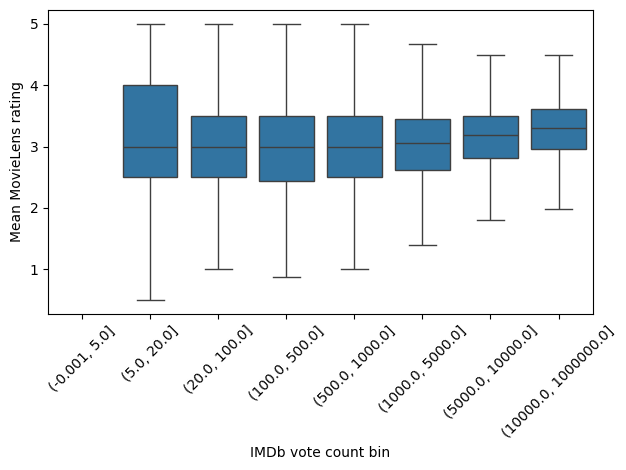

In [ ]:
movie_votes=links[["movieId","imdbId"]].merge(
    data[["imdbId","num_votes_imdb"]],
    on="imdbId",
    how="inner"
)

movie_votes=movie_votes[movie_votes["num_votes_imdb"]>0]

movie_votes["vote_bin"]=pd.cut(
    movie_votes["num_votes_imdb"],
    bins=[0,5,20,100,500,1000,5000,10000,1_000_000],
    include_lowest=True
)

movie_means=ratings.groupby("movieId",as_index=False)["rating"].mean()

df=movie_means.merge(
    movie_votes[["movieId","vote_bin"]],
    on="movieId",
    how="inner"
)

df=df.groupby("vote_bin",group_keys=False).apply(
    lambda x:x.sample(n=min(len(x),20000),random_state=34)
)

sns.boxplot(
    data=df,
    x="vote_bin",
    y="rating",
    showfliers=False
)

plt.xticks(rotation=45)
plt.xlabel("IMDb vote count bin")
plt.ylabel("Mean MovieLens rating")
plt.tight_layout()
plt.show()


### Q3. Coverage Conclusion :
* Nearly all movies (**98.82%**) have metadata.
* Although raw movie coverage is lower for some fields (e.g., backdrop=82%, writers=93%), these gaps are concentrated in the **long tail** and have negligible impact on user interactions.
* Key content fields (directors, poster, overview, keywords) all exceed **99.9%** interaction-weighted coverage

In [ ]:
meta=data[[
    "imdbId",
    "has_poster",
    "has_backdrop",
    "overview",
    "has_keywords",
    "cast_list",
    "directors",
    "writers"
]].copy()

meta["has_overview"]=meta["overview"].notna()

meta["has_cast"]=meta["cast_list"].apply(lambda x:len(x)>0)
meta["has_directors"]=meta["directors"].apply(lambda x:len(x)>0)
meta["has_writers"]=meta["writers"].apply(lambda x:len(x)>0)

movie_interactions=ratings.groupby("movieId",as_index=False).size().rename(
    columns={"size":"interaction_count"}
)

movie_interactions=movie_interactions.merge(
    links[["movieId","imdbId"]],
    on="movieId",
    how="inner"
)

df=movie_interactions.merge(
    meta,
    on="imdbId",
    how="inner"
)

total_interactions=df["interaction_count"].sum()

coverage=pd.DataFrame({
    "field":[
        "poster",
        "backdrop",
        "overview",
        "keywords",
        "cast",
        "directors",
        "writers"
    ],
    "movie_coverage":[
        df["has_poster"].mean(),
        df["has_backdrop"].mean(),
        df["has_overview"].mean(),
        df["has_keywords"].mean(),
        df["has_cast"].mean(),
        df["has_directors"].mean(),
        df["has_writers"].mean()
    ],
    "interaction_weighted_coverage":[
        df.loc[df["has_poster"],"interaction_count"].sum()/total_interactions,
        df.loc[df["has_backdrop"],"interaction_count"].sum()/total_interactions,
        df.loc[df["has_overview"],"interaction_count"].sum()/total_interactions,
        df.loc[df["has_keywords"],"interaction_count"].sum()/total_interactions,
        df.loc[df["has_cast"],"interaction_count"].sum()/total_interactions,
        df.loc[df["has_directors"],"interaction_count"].sum()/total_interactions,
        df.loc[df["has_writers"],"interaction_count"].sum()/total_interactions
    ]
})

coverage

,field,movie_coverage,interaction_weighted_coverage
0,poster,0.976740,0.999650
1,backdrop,0.820928,0.996326
2,overview,0.989970,0.999847
3,keywords,1.000000,1.000000
4,cast,0.953264,0.998588
5,directors,0.996285,0.999963
6,writers,0.934018,0.995074


In [ ]:
display("movies with metadata:",ratings["has_metadata"].mean())
ratings["has_metadata"].value_counts()

'movies with metadata:'

np.float64(0.9881829080321973)

,count
has_metadata,
True,86550
False,1035


### Q4. Cold Start Conclusion :
* Around **80%** of movies have **no ratings**, and nearly **90%** have **fewer than five**, showing that cold-start is the dominant property of the catalog.
* Cold-start rates are **similar across release years** (77-83%), so newer movies are not meaningfully better covered than older ones.
* Cold-start is much more severe for non-English movies (often **85-90%**) than for English movies (**77%**), reflecting differences in exposure.
* Cold-start decreases with **external vote support**: >99% of movies in the lowest IMDb vote bin are cold-start, while the highest-vote bin contains just 28% cold-start movies.

Note: Coverage is slightly lower for the final 2020-2030 decade as user ratings data was last updated in Oct 2023.

In [ ]:
movie_ratings=ratings.groupby("movieId").size().reset_index(name="num_ratings")

df=data[[
    "imdbId",
    "popularity",
    "release_year",
    "original_language",
    "num_votes_imdb",
    "num_votes_tmdb"
]].merge(
    links[["movieId","imdbId"]],
    on="imdbId",
    how="left"
)

df=df.merge(
    movie_ratings,
    on="movieId",
    how="left"
)

df["num_ratings"]=df["num_ratings"].fillna(0).astype(int)

df["cold_start_hard"]=df["num_ratings"]==0
df["cold_start_soft"]=df["num_ratings"]<5

overall={
    "hard_cold_start_frac":df["cold_start_hard"].mean(),
    "soft_cold_start_frac":df["cold_start_soft"].mean()
}

df["popularity_bin"]=pd.qcut(
    df["popularity"],
    q=5,
    duplicates="drop"
)

cold_by_popularity=df.groupby("popularity_bin").agg(
    movie_count=("imdbId","count"),
    hard_cold_frac=("cold_start_hard","mean"),
    soft_cold_frac=("cold_start_soft","mean")
)

df["year_bin"]=pd.cut(
    df["release_year"],
    bins=[1900,1970,1980,1990,2000,2010,2020,2030]
)

cold_by_year=df.groupby("year_bin").agg(
    movie_count=("imdbId","count"),
    hard_cold_frac=("cold_start_hard","mean"),
    soft_cold_frac=("cold_start_soft","mean")
)

cold_by_language=df.groupby("original_language").agg(
    movie_count=("imdbId","count"),
    hard_cold_frac=("cold_start_hard","mean"),
    soft_cold_frac=("cold_start_soft","mean")
).sort_values("movie_count",ascending=False)

df["imdb_votes_bin"]=pd.qcut(
    df["num_votes_imdb"],
    q=5,
    duplicates="drop"
)

cold_by_imdb_votes=df.groupby("imdb_votes_bin").agg(
    movie_count=("imdbId","count"),
    hard_cold_frac=("cold_start_hard","mean"),
    soft_cold_frac=("cold_start_soft","mean")
)

df["tmdb_votes_bin"]=pd.qcut(
    df["num_votes_tmdb"],
    q=5,
    duplicates="drop"
)

cold_by_tmdb_votes=df.groupby("tmdb_votes_bin").agg(
    movie_count=("imdbId","count"),
    hard_cold_frac=("cold_start_hard","mean"),
    soft_cold_frac=("cold_start_soft","mean")
)

pd.set_option("display.max_rows",None)
{
    "overall":overall,
    "by_popularity":cold_by_popularity,
    "by_year":cold_by_year,
    "by_language":cold_by_language,
    "by_imdb_votes":cold_by_imdb_votes,
    "by_tmdb_votes":cold_by_tmdb_votes
}

/tmp/ipython-input-3197048062.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cold_by_popularity=df.groupby("popularity_bin").agg(
/tmp/ipython-input-3197048062.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cold_by_year=df.groupby("year_bin").agg(
/tmp/ipython-input-3197048062.py:67: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cold_by_imdb_votes=df.groupby("imdb_votes_bin").agg(
/tmp/ipython-input-319704806

{'overall': {'hard_cold_start_frac': np.float64(0.8034469275848424),
  'soft_cold_start_frac': np.float64(0.8977604627937213)},
 'by_popularity':                    movie_count  hard_cold_frac  soft_cold_frac
 popularity_bin                                                
 (-0.001, 0.6]           150670        0.974215        0.997332
 (0.6, 0.661]             19256        0.958299        0.994911
 (0.661, 1.128]           84829        0.911386        0.985500
 (1.128, 2.075]           84921        0.807927        0.950036
 (2.075, 2994.357]        84876        0.352809        0.558968,
 'by_year':               movie_count  hard_cold_frac  soft_cold_frac
 year_bin                                                 
 (1900, 1970]        75860        0.817717        0.912668
 (1970, 1980]        28201        0.804440        0.904507
 (1980, 1990]        33181        0.813990        0.897471
 (1990, 2000]        40348        0.796892        0.875558
 (2000, 2010]        73635        0.78326

### Q5. Slicing Conclusion :
* Most metadata gaps are confined to the **long tail**: although backdrop coverage is only 35-43% for older eras and 33% for zero support movies, interaction-weighted coverage is **~100%**, so users rarely encounter poorly covered items.
* **Backdrop availability closely follows support**, allowing visual features to be used confidently for high-support movies and down-weighted for low-support ones.
* Overview and directors are **universally reliable** (97-100% across era, language, genre, and country), providing a stable content backbone even in low coverage slices.
* IMDb-User (MovieLens) agreement increases with IMDb vote count (p=0.38 → 0.89), so IMDb ratings should be **down-weighted for low-vote movies and trusted more as vote count grows**.
* Some Users rate nearly all items very highly (9-10), however this is treated as signal rather than noise. Handle via user bias term during modeling.

/tmp/ipython-input-3823154713.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  coverage_by_year=base.groupby("year_bin")[coverage_fields].mean()
/tmp/ipython-input-3823154713.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  coverage_by_support=base.groupby("support_bin")[coverage_fields].mean()


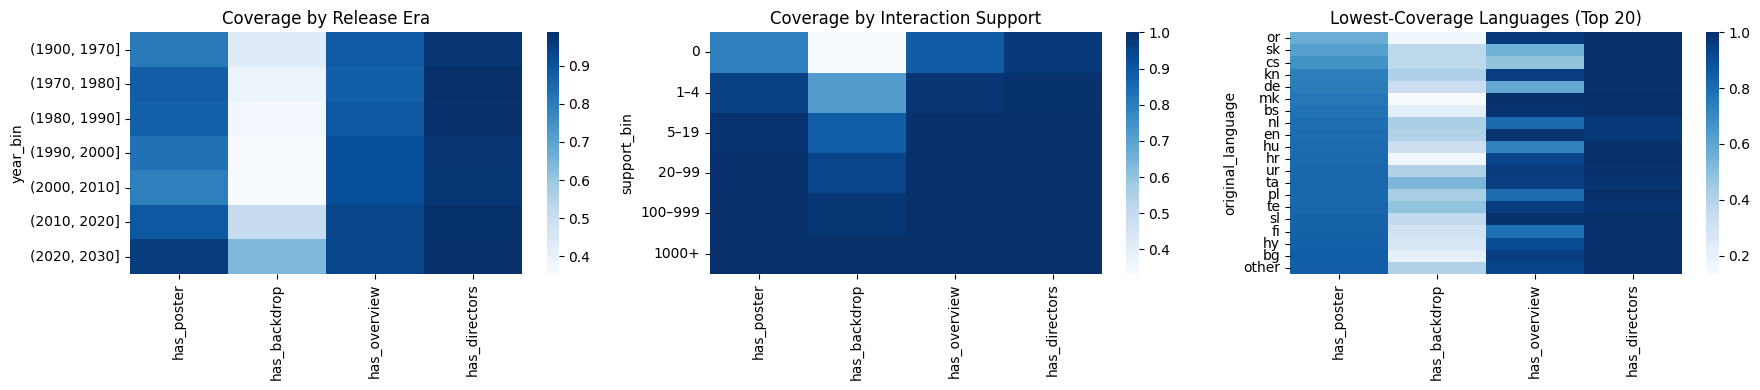

{'by_year':               has_poster  has_backdrop  has_overview  has_directors
 year_bin                                                           
 (1900, 1970]    0.810691      0.432810      0.883970       0.972845
 (1970, 1980]    0.876777      0.389915      0.873373       0.987979
 (1980, 1990]    0.866610      0.373286      0.890088       0.983846
 (1990, 2000]    0.827055      0.353698      0.912932       0.973952
 (2000, 2010]    0.797053      0.355918      0.913207       0.970191
 (2010, 2020]    0.889079      0.512105      0.935072       0.982132
 (2020, 2030]    0.959191      0.638741      0.937570       0.984127,
 'by_support':              has_poster  has_backdrop  has_overview  has_directors
 support_bin                                                       
 0              0.798522      0.332610      0.885856       0.972205
 1–4            0.960132      0.720191      0.982871       0.993884
 5–19           0.991401      0.882156      0.996307       0.998038
 20–99       

In [ ]:
base=data[[
    "imdbId",
    "release_year",
    "original_language",
    "production_countries",
    "genres",
    "overview",
    "directors",
    "has_poster",
    "has_backdrop"
]].copy()

base["has_overview"]=base["overview"].notna() & (base["overview"].str.len()>0)
base["has_directors"]=base["directors"].apply(lambda x:len(x)>0)
coverage_fields=[
    "has_poster",
    "has_backdrop",
    "has_overview",
    "has_directors"
]

movie_ratings=ratings.groupby("movieId").size().reset_index(name="num_ratings")

base=base.merge(
    links[["movieId","imdbId"]],
    on="imdbId",
    how="left"
).merge(
    movie_ratings,
    on="movieId",
    how="left"
)

base["num_ratings"]=base["num_ratings"].fillna(0)

base["year_bin"]=pd.cut(
    base["release_year"],
    bins=[1900,1970,1980,1990,2000,2010,2020,2030]
)

base["support_bin"]=pd.cut(
    base["num_ratings"],
    bins=[-1,0,5,20,100,1000,1_000_000],
    labels=["0","1–4","5–19","20–99","100–999","1000+"]
)

def explode_and_aggregate(df,col):
    tmp=df[[col,*coverage_fields]].explode(col)
    return tmp.groupby(col)[coverage_fields].mean()

coverage_by_year=base.groupby("year_bin")[coverage_fields].mean()
coverage_by_language=base.groupby("original_language")[coverage_fields].mean()
coverage_by_support=base.groupby("support_bin")[coverage_fields].mean()
coverage_by_genre=explode_and_aggregate(base,"genres")
coverage_by_country=explode_and_aggregate(base,"production_countries")

fig,axs=plt.subplots(1,3,figsize=(18,4))

sns.heatmap(
    coverage_by_year,
    cmap="Blues",
    ax=axs[0]
)
axs[0].set_title("Coverage by Release Era")

sns.heatmap(
    coverage_by_support,
    cmap="Blues",
    ax=axs[1]
)
axs[1].set_title("Coverage by Interaction Support")

low_lang=coverage_by_language.sort_values("has_poster").head(20)
sns.heatmap(
    low_lang,
    cmap="Blues",
    ax=axs[2]
)
axs[2].set_title("Lowest-Coverage Languages (Top 20)")

plt.tight_layout()
plt.show()

{
    "by_year":coverage_by_year,
    "by_support":coverage_by_support,
    "by_language":coverage_by_language,
    "by_genre":coverage_by_genre,
    "by_country":coverage_by_country
}

/tmp/ipython-input-3487565854.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  iw_year=base.groupby("year_bin",observed=False).apply(interaction_weighted_coverage)
/tmp/ipython-input-3487565854.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  iw_support=base.groupby("support_bin",observed=False).apply(interaction_weighted_coverage)


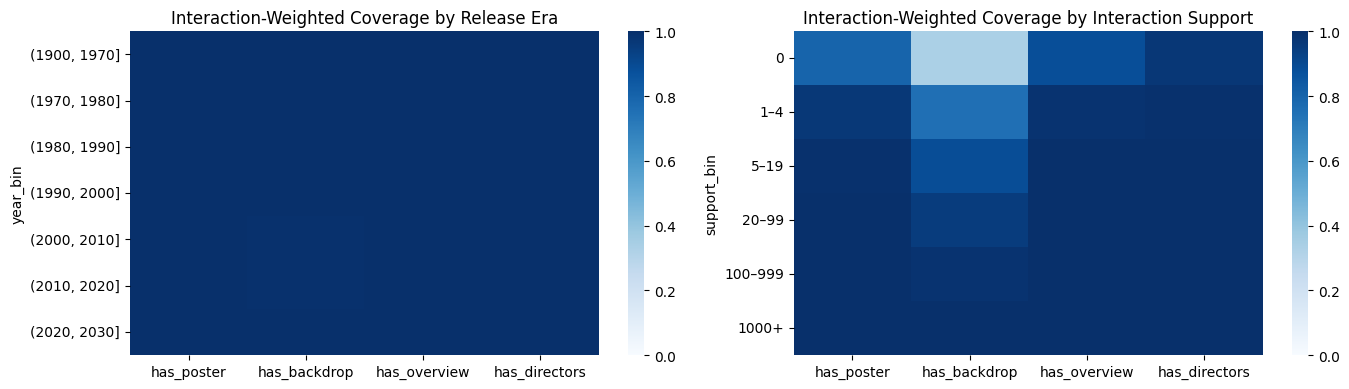

In [ ]:
def interaction_weighted_coverage(df):
    w=df["num_ratings"].sum()
    return pd.Series({
        f:(df[f]*df["num_ratings"]).sum()/w if w>0 else df[f].mean()
        for f in coverage_fields
    })

iw_year=base.groupby("year_bin",observed=False).apply(interaction_weighted_coverage)
iw_support=base.groupby("support_bin",observed=False).apply(interaction_weighted_coverage)

fig,axs=plt.subplots(1,2,figsize=(14,4))

sns.heatmap(
    iw_year,
    cmap="Blues",
    vmin=0,
    vmax=1,
    ax=axs[0]
)
axs[0].set_title("Interaction-Weighted Coverage by Release Era")

sns.heatmap(
    iw_support,
    cmap="Blues",
    vmin=0,
    vmax=1,
    ax=axs[1]
)
axs[1].set_title("Interaction-Weighted Coverage by Interaction Support")

plt.tight_layout()
plt.show()

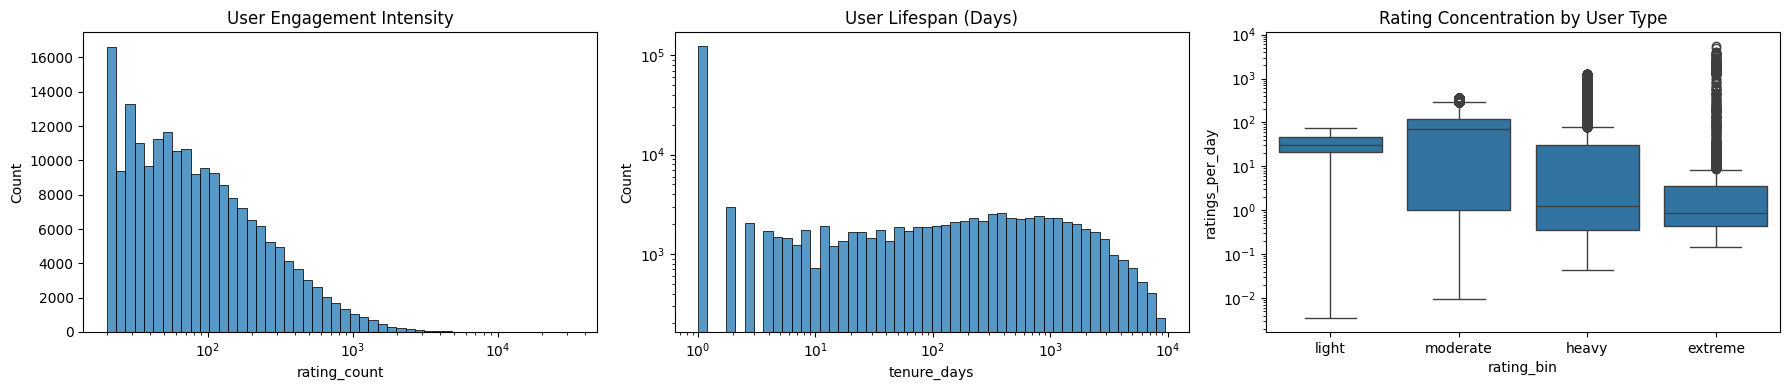

/tmp/ipython-input-253984913.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  "concentration_summary":u.groupby("rating_bin")["ratings_per_day"].describe()


{'engagement_summary': count    200948.000000
 mean        159.246193
 std         282.025462
 min          20.000000
 25%          36.000000
 50%          73.000000
 75%         167.000000
 max       33332.000000
 Name: rating_count, dtype: float64,
 'tenure_summary': count    200948.000000
 mean        259.470147
 std         821.809332
 min           1.000000
 25%           1.000000
 50%           1.000000
 75%          53.000000
 max        9515.000000
 Name: tenure_days, dtype: float64,
 'concentration_summary':                count        mean         std       min        25%        50%  \
 rating_bin                                                                     
 light       101310.0   31.974650   19.314123  0.003452  21.000000  30.000000   
 moderate     79602.0   73.812648   81.912292  0.009706   0.990373  70.666667   
 heavy        18028.0   98.975243  213.026917  0.043581   0.363359   1.255859   
 extreme       2008.0  151.976315  540.132335  0.144032   0.430635   0.88

In [ ]:
u=users.copy()

u["tenure_days"]=(u["last_rating"]-u["first_rating"]).dt.days.clip(lower=1)
u["ratings_per_day"]=u["rating_count"]/u["tenure_days"]

u["rating_bin"]=pd.qcut(
    u["rating_count"],
    q=[0,0.5,0.9,0.99,1.0],
    labels=["light","moderate","heavy","extreme"]
)

fig,axs=plt.subplots(1,3,figsize=(18,4))

sns.histplot(
    u["rating_count"],
    bins=50,
    log_scale=True,
    ax=axs[0]
)
axs[0].set_title("User Engagement Intensity")

sns.histplot(
    u["tenure_days"],
    bins=50,
    log_scale=True,
    ax=axs[1]
)
axs[1].set_yscale("log")
axs[1].set_title("User Lifespan (Days)")

sns.boxplot(
    x="rating_bin",
    y="ratings_per_day",
    data=u,
    ax=axs[2]
)
axs[2].set_yscale("log")
axs[2].set_title("Rating Concentration by User Type")

plt.tight_layout()
plt.show()

{
    "engagement_summary":u["rating_count"].describe(),
    "tenure_summary":u["tenure_days"].describe(),
    "concentration_summary":u.groupby("rating_bin")["ratings_per_day"].describe()
}

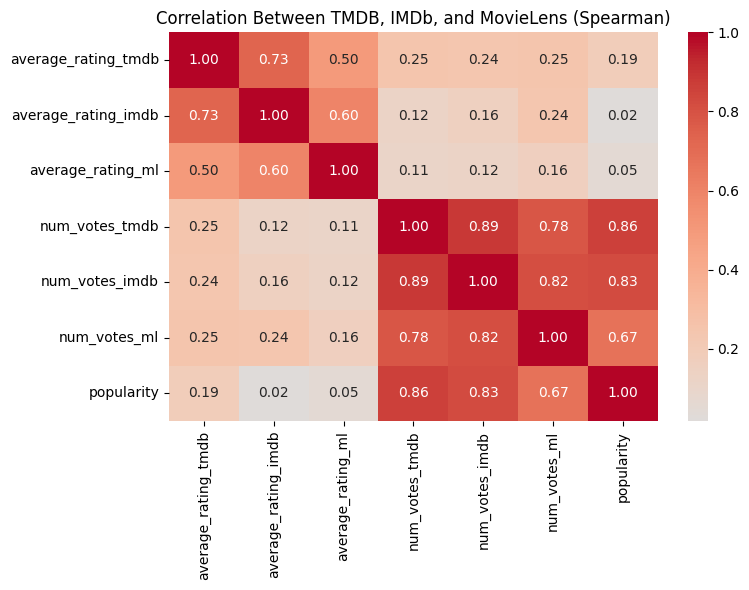

In [ ]:
ml_movie_stats=ratings.groupby("movieId").agg(
    average_rating_ml=("rating","mean"),
    num_votes_ml=("rating","count")
).reset_index()

corr_df=data[[
    "imdbId",
    "average_rating_tmdb",
    "num_votes_tmdb",
    "average_rating_imdb",
    "num_votes_imdb",
    "popularity"
]].merge(
    links[["movieId","imdbId"]],
    on="imdbId",
    how="inner"
).merge(
    ml_movie_stats,
    on="movieId",
    how="inner"
)

corr_df=corr_df[[
    "average_rating_tmdb",
    "average_rating_imdb",
    "average_rating_ml",
    "num_votes_tmdb",
    "num_votes_imdb",
    "num_votes_ml",
    "popularity"
]].dropna()

corr=corr_df.corr(method="spearman")

plt.figure(figsize=(8,6))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title("Correlation Between TMDB, IMDb, and MovieLens (Spearman)")
plt.tight_layout()
plt.show()

/tmp/ipython-input-4132494709.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g:g[["average_rating_ml","average_rating_imdb"]]


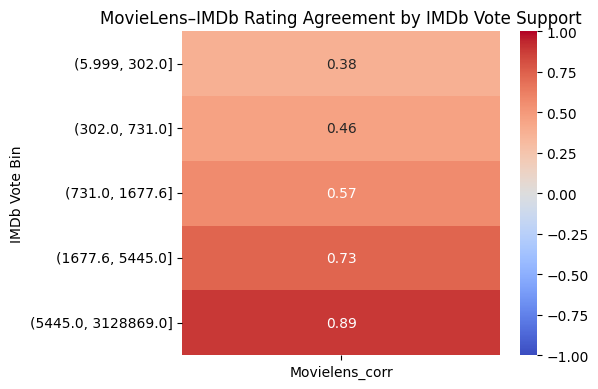

In [ ]:
ml_movie_stats=ratings.groupby("movieId").agg(
    average_rating_ml=("rating","mean"),
    ml_num_ratings=("rating","count")
).reset_index()

df=data[[
    "imdbId",
    "average_rating_imdb",
    "num_votes_imdb"
]].merge(
    links[["movieId","imdbId"]],
    on="imdbId",
    how="inner"
).merge(
    ml_movie_stats,
    on="movieId",
    how="inner"
)

df=df.dropna(subset=["average_rating_ml","average_rating_imdb","num_votes_imdb"])

df["imdb_votes_bin"]=pd.qcut(
    df["num_votes_imdb"],
    q=5,
    duplicates="drop"
)

corr_by_bin=(
    df.groupby("imdb_votes_bin",observed=False)
      .apply(lambda g:g[["average_rating_ml","average_rating_imdb"]]
             .corr(method="spearman")
             .iloc[0,1])
      .to_frame(name="Movielens_corr")
)

plt.figure(figsize=(6,4))
sns.heatmap(
    corr_by_bin,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1
)
plt.title("MovieLens–IMDb Rating Agreement by IMDb Vote Support")
plt.ylabel("IMDb Vote Bin")
plt.xlabel("")
plt.tight_layout()
plt.show()

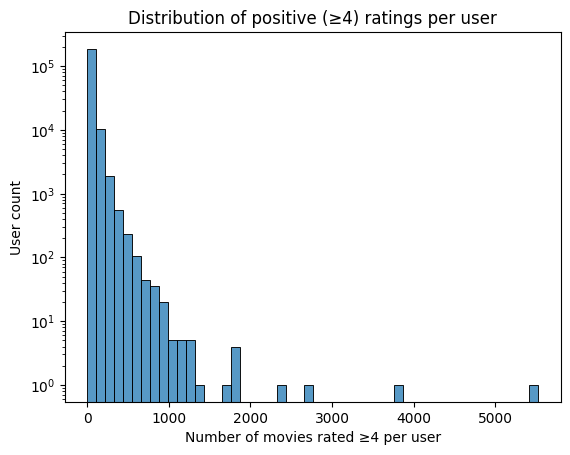

In [ ]:
user_pos_counts=(
    ratings[ratings["rating"]>4]
    .groupby("userId")
    .size()
    .rename("num_positive")
)

sns.histplot(user_pos_counts,bins=50)
plt.xlabel("Number of movies rated ≥4 per user")
plt.ylabel("User count")
plt.yscale("log")
plt.title("Distribution of positive (≥4) ratings per user")
plt.show()


In [ ]:
user_total_counts=ratings.groupby("userId").size().rename("total_ratings")
user_pos_counts=ratings[ratings["rating"]>4].groupby("userId").size().rename("positive_ratings")

user_stats=pd.concat([user_total_counts,user_pos_counts],axis=1).fillna(0).astype(int)

heavy_positive_users=user_stats[user_stats["positive_ratings"]>1500][
    ["total_ratings","positive_ratings"]
]

heavy_positive_users


,total_ratings,positive_ratings
userId,,
6728,3389,1794
23783,3852,3852
71601,1728,1706
82050,4681,1879
87007,5525,5525
103925,5655,2694
113165,2904,1857
132423,3121,2390
175325,33332,1782


## Key Takeaways

**Popularity bias and filter-bubble risk evidence:**
* User interaction distribution is **extremely skewed**:
Rating counts has a **heavy right tail** where a small group of users generate a disproportionate share of ratings.
* Movie support is **highly concentrated**:
Cold-start results show ~80% of movies have zero MovieLens ratings, while interaction-weighted coverage is ~100%. This means **most user activity focuses on a small fraction** of well-known movies.
* Agreement and metadata quality track support:
High support movies have near-perfect metadata coverage and strong IMDb-User agreement, **reinforcing exposure of popular movies**.

**Mitigation**: Reweight training loss by inverse item popularity (or cap per-item interactions), add explicit long-tail sampling/exploration, and combine collaborative signals with content features to prevent over-amplifying already-popular movies.

---

**Temporal split strategy evidence:**

* Random splits risk leaking future behavior.
* Time coverage is uneven across users and movies, so training on later interactions can inflate training performance compared to actual performance.

**Recommendation:** Use **chronological, user-based holdout** ,add a rolling-window, and use leave-movie-out only for a separate cold-start probe.

---

**Stratified test/validation evidence:**

* Catalog is long-tailed: **~80%** movies have 0 ratings and ~90% <=5, so random test sets over-index the head.
* Language and release-year slices show systematic under-exposure that must be measured separately.

**Recommendation:** Create explicit strata and ensure representation in test/val: **hard cold-start (0 ratings), soft (1–4), weak (5–19), head (≥20)**, plus **rare-language** and **recent-release** slices. Report results per stratum and include a blended overall metric.

---

**Metric choice & slice reporting evidence:**

* Error metrics like RMSE are head-dominated and hide tail failure.
* Ranking and exposure-aware metrics better reflect product goals for recommendations.

**Recommendation:** Report **NDCG@K / Recall@K / MAP@K** (K=5,10,20) as primary ranking metrics plus **RMSE** for rating tasks. Also report **diversity/novelty/coverage** and always slice metrics by **support bins, language, and release-era**.
